<a href="https://colab.research.google.com/github/aaart42/trading_pub/blob/main/RiskPremiaResearch_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Define the ETF
etf = ["GLD", "TLT", "VTI"]

# Define windows (fest codiert, start with 30 days)
lookback = 30
look_forward = 30

In [13]:
# Download historical data
data = yf.download(etf, period='max', auto_adjust=False)

# Extract adjusted close prices
adj_close = data["Adj Close"]

# Flatten to long format
adj_long = pd.melt(
    adj_close.reset_index(),
    id_vars=['Date'],
    value_vars=etf,
    var_name='Ticker',
    value_name='Price'
).set_index('Date')

[*********************100%***********************]  3 of 3 completed


In [23]:
# Calculate daily returns
adj_long['returns'] = adj_long.groupby('Ticker')['Price'].pct_change(fill_method=None)

# Sort by Ticker and Date (important for shift)
adj_long = adj_long.sort_values(['Ticker', 'Date'])

In [24]:
# Calculate  backward log returns: log(price_today / price_x_days_ago)
adj_long['back_returns'] = np.log(
    adj_long['Price'] / adj_long.groupby('Ticker')['Price'].shift(lookback)
)
adj_long

,Ticker,Price,returns,back_returns,forward_return
Date,,,,,
2001-06-15,GLD,NaN,NaN,NaN,NaN
2001-06-18,GLD,NaN,NaN,NaN,NaN
2001-06-19,GLD,NaN,NaN,NaN,NaN
2001-06-20,GLD,NaN,NaN,NaN,NaN
2001-06-21,GLD,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-09-22,VTI,329.859985,0.004323,0.052369,NaN
2025-09-23,VTI,328.089996,-0.005366,0.049292,NaN
2025-09-24,VTI,326.890015,-0.003657,0.033470,NaN


In [25]:
# Calculate forward log returns: log(price_in_x_days / price_today)
adj_long['forward_return'] = np.log(
    adj_long.groupby('Ticker')['Price'].shift(-look_forward) / adj_long['Price']
)
adj_long

,Ticker,Price,returns,back_returns,forward_return
Date,,,,,
2001-06-15,GLD,NaN,NaN,NaN,NaN
2001-06-18,GLD,NaN,NaN,NaN,NaN
2001-06-19,GLD,NaN,NaN,NaN,NaN
2001-06-20,GLD,NaN,NaN,NaN,NaN
2001-06-21,GLD,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-09-22,VTI,329.859985,0.004323,0.052369,NaN
2025-09-23,VTI,328.089996,-0.005366,0.049292,NaN
2025-09-24,VTI,326.890015,-0.003657,0.033470,NaN


In [26]:
adj_long_clean = adj_long.dropna().copy()

In [27]:
adj_long_clean["row"] = adj_long_clean.groupby('Ticker').cumcount() + 1
adj_long_clean

,Ticker,Price,returns,back_returns,forward_return,row
Date,,,,,,
2005-01-03,GLD,43.020000,-0.017808,-0.031124,-0.010280,1
2005-01-04,GLD,42.740002,-0.006509,-0.046626,-0.005161,2
2005-01-05,GLD,42.669998,-0.001638,-0.052055,0.001405,3
2005-01-06,GLD,42.150002,-0.012186,-0.059857,0.014134,4
2005-01-07,GLD,41.840000,-0.007355,-0.073920,0.040516,5
...,...,...,...,...,...,...
2025-08-08,VTI,313.029999,0.006301,0.039085,0.052369,6043
2025-08-11,VTI,312.309998,-0.002300,0.032256,0.049292,6044
2025-08-12,VTI,316.130005,0.012231,0.039356,0.033470,6045


## Overlapping graph

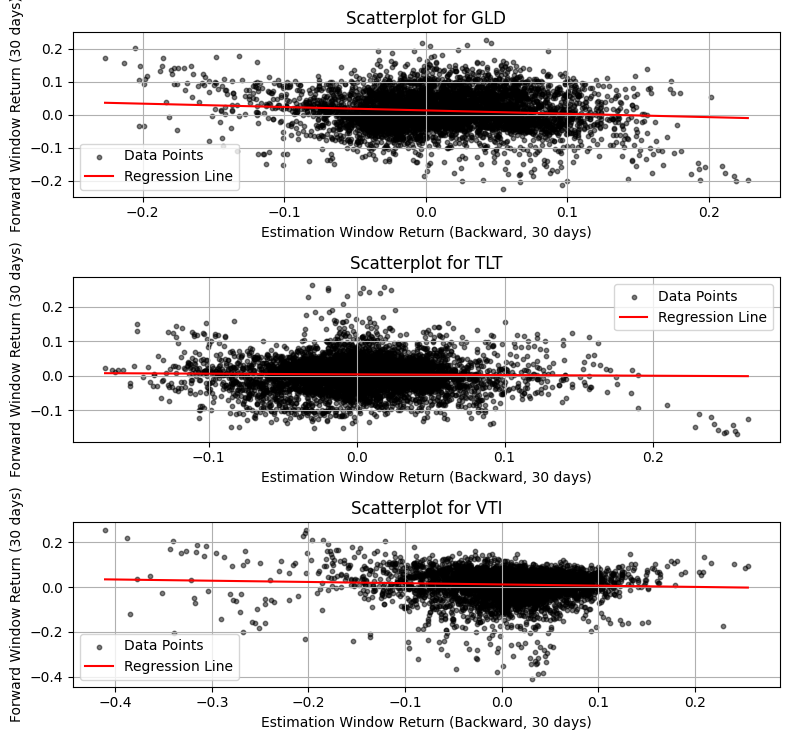

In [28]:
# Create scatter plots for each ETF, stacked vertically, with independent scaling
fig, axs = plt.subplots(len(etf), 1, figsize=(8, 2.5 * len(etf)), sharex=False, sharey=False)

for i, ticker in enumerate(etf):
    subset = adj_long_clean[adj_long_clean['Ticker'] == ticker]

    # Scatter plot: back_returns on x, forward_return on y
    axs[i].scatter(subset['back_returns'], subset['forward_return'], alpha=0.5, s=10, color='black', label='Data Points')

    # Linear regression (add regression line)
    if len(subset) > 1:  # Need at least 2 points for regression
        result = linregress(subset['back_returns'], subset['forward_return'])
        x_vals = np.array([subset['back_returns'].min(), subset['back_returns'].max()])
        y_vals = result.slope * x_vals + result.intercept
        axs[i].plot(x_vals, y_vals, color='red', label='Regression Line')

    # Set title with ticker name
    axs[i].set_title(f'Scatterplot for {ticker}')

    axs[i].set_xlabel('Estimation Window Return (Backward, {} days)'.format(lookback))
    axs[i].set_ylabel('Forward Window Return ({} days)'.format(look_forward))
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

## Non-overlapping graph

In [20]:
# Filter for non-overlapping periods: every "lookback" row
adj_long_non_overlapping = adj_long_clean[adj_long_clean['row'] % lookback == 1]
adj_long_non_overlapping

,Ticker,Price,returns,back_returns,forward_return,row
Date,,,,,,
2005-01-03,GLD,43.020000,-0.017808,-0.031124,-0.010280,1
2005-02-15,GLD,42.580002,0.000705,-0.010280,0.005621,31
2005-03-31,GLD,42.820000,0.004928,0.005621,-0.015533,61
2005-05-12,GLD,42.160000,-0.012415,-0.015533,0.040442,91
2005-06-24,GLD,43.900002,-0.002726,0.040442,-0.012608,121
...,...,...,...,...,...,...
2025-01-29,VTI,296.429718,-0.004272,-0.002501,-0.095552,5911
2025-03-13,VTI,269.416534,-0.014034,-0.095552,0.001516,5941
2025-04-25,VTI,269.825348,0.006134,0.001516,0.087405,5971


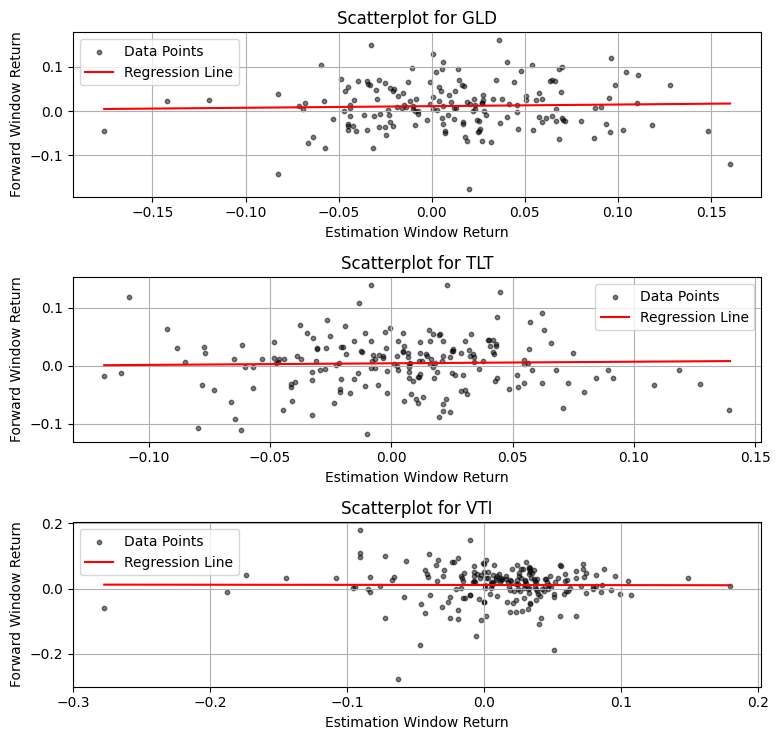

In [21]:
# Create scatter plots for each ETF, stacked vertically, with independent scaling
fig, axs = plt.subplots(len(etf), 1, figsize=(8, 2.5 * len(etf)), sharex=False, sharey=False)

for i, ticker in enumerate(etf):
    subset = adj_long_non_overlapping[adj_long_non_overlapping['Ticker'] == ticker]

    # Scatter plot: back_returns on x, forward_return on y
    axs[i].scatter(subset['back_returns'], subset['forward_return'], alpha=0.5, s=10, color='black', label='Data Points')

    # Linear regression (add regression line)
    if len(subset) > 1:  # Need at least 2 points for regression
        result = linregress(subset['back_returns'], subset['forward_return'])
        x_vals = np.array([subset['back_returns'].min(), subset['back_returns'].max()])
        y_vals = result.slope * x_vals + result.intercept
        axs[i].plot(x_vals, y_vals, color='red', label='Regression Line')

    # Set title with ticker name
    axs[i].set_title(f'Scatterplot for {ticker}')

    axs[i].set_xlabel('Estimation Window Return')
    axs[i].set_ylabel('Forward Window Return')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()